In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 8.6 MB/s 
     |████████████████████████████████| 190 kB 4.1 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7020, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 7020 (delta 9), reused 27 (delta 8), pack-reused 6988
Receiving objects: 100% (7020/7020), 13.03 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (5197/5197), done.


In [5]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [6]:
%cd mmsegmentation

/content/mmsegmentation


In [7]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [8]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-20 00:46:55--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.28
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  8.64MB/s    in 37s     

2022-05-20 00:47:34 (8.35 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [10]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building', 'road')
palette = [[0, 0, 0], [128, 128, 0], [255, 255, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [11]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [12]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [13]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 512)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [14]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
            dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [15]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 3

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0), dict(type='FocalLoss', loss_weight=1.0), dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]

In [16]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [17]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/road_dataset/ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_train_road.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/road_dataset/ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_val_road.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/road_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/road_dataset/ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/val/up.txt'

In [18]:
'''
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'
'''

"\ncfg.data.train.type = 'SIADataset'\ncfg.data.train.data_root = '/content/drive/MyDrive/SIA'\ncfg.data.train.img_dir = 'images/up025'\ncfg.data.train.ann_dir = 'labels'\ncfg.data.train.pipeline = cfg.train_pipeline\ncfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'\n"

In [19]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz'

In [20]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [19]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-19 15:43:01,770 - mmseg - INFO - Loaded 542 images
2022-05-19 15:43:16,923 - mmseg - INFO - Loaded 66 images
2022-05-19 15:43:16,927 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-19 15:43:17,373 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-19 15:43:17,381 - mmseg - INFO - Start running, host: root@89ccd62589d4, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz
2022-05-19 15:43:17,382 - mmseg - INFO - Hooks will be executed in the following order:
before_run

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.1 task/s, elapsed: 58s, ETA:     0s

2022-05-19 15:57:00,655 - mmseg - INFO - per class results:
2022-05-19 15:57:00,658 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.54 | 95.32 |
|  building  |  nan  |  nan  |
|    road    | 55.93 | 68.65 |
+------------+-------+-------+
2022-05-19 15:57:00,659 - mmseg - INFO - Summary:
2022-05-19 15:57:00,661 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.77 | 72.74 | 81.98 |
+-------+-------+-------+
2022-05-19 15:57:00,663 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9077, mIoU: 0.7274, mAcc: 0.8198, IoU.background: 0.8954, IoU.building: nan, IoU.road: 0.5593, Acc.background: 0.9532, Acc.building: nan, Acc.road: 0.6865
2022-05-19 15:57:42,275 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:07:39, time: 0.999, data_time: 0.610, memory: 3323, decode.loss_dice: 0.0974, decode.loss_focal: 0.0374, decode.loss_lovasz: 0.2884, decode.acc_seg: 89.1906, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.0 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:04:21,835 - mmseg - INFO - per class results:
2022-05-19 16:04:21,837 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.25 | 94.78 |
|  building  |  nan  |  nan  |
|    road    | 60.32 | 75.62 |
+------------+-------+-------+
2022-05-19 16:04:21,837 - mmseg - INFO - Summary:
2022-05-19 16:04:21,840 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.51 | 75.29 | 85.2 |
+-------+-------+------+
2022-05-19 16:04:21,842 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9151, mIoU: 0.7529, mAcc: 0.8520, IoU.background: 0.9025, IoU.building: nan, IoU.road: 0.6032, Acc.background: 0.9478, Acc.building: nan, Acc.road: 0.7562
2022-05-19 16:05:01,369 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 3:05:14, time: 0.732, data_time: 0.342, memory: 3323, decode.loss_dice: 0.0860, decode.loss_focal: 0.0294, decode.loss_lovasz: 0.2609, decode.acc_seg: 91.0838, loss: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.0 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:11:41,279 - mmseg - INFO - per class results:
2022-05-19 16:11:41,281 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.87 | 95.35 |
|  building  |  nan  |  nan  |
|    road    | 62.01 | 76.01 |
+------------+-------+-------+
2022-05-19 16:11:41,282 - mmseg - INFO - Summary:
2022-05-19 16:11:41,284 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.05 | 76.44 | 85.68 |
+-------+-------+-------+
2022-05-19 16:11:41,286 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9205, mIoU: 0.7644, mAcc: 0.8568, IoU.background: 0.9087, IoU.building: nan, IoU.road: 0.6201, Acc.background: 0.9535, Acc.building: nan, Acc.road: 0.7601
2022-05-19 16:12:20,899 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 2:38:24, time: 0.734, data_time: 0.343, memory: 3323, decode.loss_dice: 0.0882, decode.loss_focal: 0.0287, decode.loss_lovasz: 0.2666, decode.acc_seg: 91.0843, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.0 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:19:04,116 - mmseg - INFO - per class results:
2022-05-19 16:19:04,118 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.11 | 95.52 |
|  building  |  nan  |  nan  |
|    road    | 62.78 | 76.44 |
+------------+-------+-------+
2022-05-19 16:19:04,121 - mmseg - INFO - Summary:
2022-05-19 16:19:04,123 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.27 | 76.94 | 85.98 |
+-------+-------+-------+
2022-05-19 16:19:04,125 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9227, mIoU: 0.7694, mAcc: 0.8598, IoU.background: 0.9111, IoU.building: nan, IoU.road: 0.6278, Acc.background: 0.9552, Acc.building: nan, Acc.road: 0.7644
2022-05-19 16:19:44,061 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 2:21:19, time: 0.738, data_time: 0.344, memory: 3323, decode.loss_dice: 0.0770, decode.loss_focal: 0.0330, decode.loss_lovasz: 0.2418, decode.acc_seg: 91.4996, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.0 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:26:29,576 - mmseg - INFO - per class results:
2022-05-19 16:26:29,578 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.18 | 96.04 |
|  building  |  nan  |  nan  |
|    road    | 62.15 | 74.11 |
+------------+-------+-------+
2022-05-19 16:26:29,579 - mmseg - INFO - Summary:
2022-05-19 16:26:29,581 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.3 | 76.67 | 85.07 |
+------+-------+-------+
2022-05-19 16:26:29,582 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9230, mIoU: 0.7667, mAcc: 0.8507, IoU.background: 0.9118, IoU.building: nan, IoU.road: 0.6215, Acc.background: 0.9604, Acc.building: nan, Acc.road: 0.7411
2022-05-19 16:27:09,841 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 2:08:10, time: 0.741, data_time: 0.344, memory: 3323, decode.loss_dice: 0.0779, decode.loss_focal: 0.0267, decode.loss_lovasz: 0.2388, decode.acc_seg: 92.0365, loss: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.0 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:33:57,186 - mmseg - INFO - per class results:
2022-05-19 16:33:57,187 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.9 | 94.78 |
|  building  |  nan  |  nan  |
|    road    | 63.23 | 79.26 |
+------------+-------+-------+
2022-05-19 16:33:57,188 - mmseg - INFO - Summary:
2022-05-19 16:33:57,191 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.13 | 77.07 | 87.02 |
+-------+-------+-------+
2022-05-19 16:33:57,193 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9213, mIoU: 0.7707, mAcc: 0.8702, IoU.background: 0.9090, IoU.building: nan, IoU.road: 0.6323, Acc.background: 0.9478, Acc.building: nan, Acc.road: 0.7926
2022-05-19 16:34:36,750 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 1:56:56, time: 0.732, data_time: 0.342, memory: 3323, decode.loss_dice: 0.0793, decode.loss_focal: 0.0244, decode.loss_lovasz: 0.2368, decode.acc_seg: 92.1667, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.0 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:41:22,191 - mmseg - INFO - per class results:
2022-05-19 16:41:22,192 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.62 | 96.61 |
|  building  |  nan  |  nan  |
|    road    | 63.13 | 73.53 |
+------------+-------+-------+
2022-05-19 16:41:22,193 - mmseg - INFO - Summary:
2022-05-19 16:41:22,195 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.67 | 77.37 | 85.07 |
+-------+-------+-------+
2022-05-19 16:41:22,198 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9267, mIoU: 0.7737, mAcc: 0.8507, IoU.background: 0.9162, IoU.building: nan, IoU.road: 0.6313, Acc.background: 0.9661, Acc.building: nan, Acc.road: 0.7353
2022-05-19 16:42:04,681 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 1:46:48, time: 0.763, data_time: 0.365, memory: 3323, decode.loss_dice: 0.0727, decode.loss_focal: 0.0239, decode.loss_lovasz: 0.2286, decode.acc_seg: 92.5829, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 2.0 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:48:48,723 - mmseg - INFO - per class results:
2022-05-19 16:48:48,725 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.49 | 95.86 |
|  building  |  nan  |  nan  |
|    road    | 63.92 | 76.78 |
+------------+-------+-------+
2022-05-19 16:48:48,726 - mmseg - INFO - Summary:
2022-05-19 16:48:48,728 - mmseg - INFO - 
+------+------+-------+
| aAcc | mIoU |  mAcc |
+------+------+-------+
| 92.6 | 77.7 | 86.32 |
+------+------+-------+
2022-05-19 16:48:48,731 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9260, mIoU: 0.7770, mAcc: 0.8632, IoU.background: 0.9149, IoU.building: nan, IoU.road: 0.6392, Acc.background: 0.9586, Acc.building: nan, Acc.road: 0.7678
2022-05-19 16:49:28,886 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 1:37:14, time: 0.740, data_time: 0.343, memory: 3323, decode.loss_dice: 0.0720, decode.loss_focal: 0.0241, decode.loss_lovasz: 0.2220, decode.acc_seg: 92.4715, loss: 0.318

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 16:56:16,684 - mmseg - INFO - per class results:
2022-05-19 16:56:16,686 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.64 | 96.28 |
|  building  |  nan  |  nan  |
|    road    | 63.84 | 75.37 |
+------------+-------+-------+
2022-05-19 16:56:16,687 - mmseg - INFO - Summary:
2022-05-19 16:56:16,691 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.71 | 77.74 | 85.82 |
+-------+-------+-------+
2022-05-19 16:56:16,692 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9271, mIoU: 0.7774, mAcc: 0.8582, IoU.background: 0.9164, IoU.building: nan, IoU.road: 0.6384, Acc.background: 0.9628, Acc.building: nan, Acc.road: 0.7537
2022-05-19 16:56:56,867 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 1:28:13, time: 0.741, data_time: 0.345, memory: 3323, decode.loss_dice: 0.0737, decode.loss_focal: 0.0250, decode.loss_lovasz: 0.2233, decode.acc_seg: 92.5392, l

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 17:03:43,642 - mmseg - INFO - per class results:
2022-05-19 17:03:43,644 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.44 | 95.41 |
|  building  |  nan  |  nan  |
|    road    |  64.5 | 78.88 |
+------------+-------+-------+
2022-05-19 17:03:43,645 - mmseg - INFO - Summary:
2022-05-19 17:03:43,646 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.59 | 77.97 | 87.15 |
+-------+-------+-------+
2022-05-19 17:03:43,647 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9259, mIoU: 0.7797, mAcc: 0.8715, IoU.background: 0.9144, IoU.building: nan, IoU.road: 0.6450, Acc.background: 0.9541, Acc.building: nan, Acc.road: 0.7888
2022-05-19 17:04:23,685 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 1:19:29, time: 0.742, data_time: 0.347, memory: 3323, decode.loss_dice: 0.0613, decode.loss_focal: 0.0209, decode.loss_lovasz: 0.2032, decode.acc_seg: 93.3569, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 17:11:09,054 - mmseg - INFO - per class results:
2022-05-19 17:11:09,055 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.52 | 95.77 |
|  building  |  nan  |  nan  |
|    road    | 64.22 | 77.43 |
+------------+-------+-------+
2022-05-19 17:11:09,057 - mmseg - INFO - Summary:
2022-05-19 17:11:09,058 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.64 | 77.87 | 86.6 |
+-------+-------+------+
2022-05-19 17:11:09,060 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9264, mIoU: 0.7787, mAcc: 0.8660, IoU.background: 0.9152, IoU.building: nan, IoU.road: 0.6422, Acc.background: 0.9577, Acc.building: nan, Acc.road: 0.7743
2022-05-19 17:11:48,978 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:10:58, time: 0.742, data_time: 0.348, memory: 3323, decode.loss_dice: 0.0663, decode.loss_focal: 0.0226, decode.loss_lovasz: 0.2128, decode.acc_seg: 93.2732, loss:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 17:18:32,209 - mmseg - INFO - per class results:
2022-05-19 17:18:32,211 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.52 | 95.36 |
|  building  |  nan  |  nan  |
|    road    | 64.99 | 79.66 |
+------------+-------+-------+
2022-05-19 17:18:32,212 - mmseg - INFO - Summary:
2022-05-19 17:18:32,217 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.68 | 78.26 | 87.51 |
+-------+-------+-------+
2022-05-19 17:18:32,218 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9268, mIoU: 0.7826, mAcc: 0.8751, IoU.background: 0.9152, IoU.building: nan, IoU.road: 0.6499, Acc.background: 0.9536, Acc.building: nan, Acc.road: 0.7966
2022-05-19 17:19:11,987 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:02:37, time: 0.741, data_time: 0.349, memory: 3323, decode.loss_dice: 0.0647, decode.loss_focal: 0.0235, decode.loss_lovasz: 0.2089, decode.acc_seg: 92.8830, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 17:25:53,833 - mmseg - INFO - per class results:
2022-05-19 17:25:53,835 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  91.7 | 96.14 |
|  building  |  nan  |  nan  |
|    road    | 64.38 | 76.47 |
+------------+-------+-------+
2022-05-19 17:25:53,836 - mmseg - INFO - Summary:
2022-05-19 17:25:53,840 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.78 | 78.04 | 86.3 |
+-------+-------+------+
2022-05-19 17:25:53,841 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9278, mIoU: 0.7804, mAcc: 0.8630, IoU.background: 0.9170, IoU.building: nan, IoU.road: 0.6438, Acc.background: 0.9614, Acc.building: nan, Acc.road: 0.7647
2022-05-19 17:26:35,841 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 0:54:24, time: 0.764, data_time: 0.370, memory: 3323, decode.loss_dice: 0.0675, decode.loss_focal: 0.0221, decode.loss_lovasz: 0.1987, decode.acc_seg: 93.6054, loss:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 17:33:16,637 - mmseg - INFO - per class results:
2022-05-19 17:33:16,639 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.79 | 95.99 |
|  building  |  nan  |  nan  |
|    road    |  65.1 | 77.78 |
+------------+-------+-------+
2022-05-19 17:33:16,640 - mmseg - INFO - Summary:
2022-05-19 17:33:16,641 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.88 | 78.45 | 86.89 |
+-------+-------+-------+
2022-05-19 17:33:16,643 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9288, mIoU: 0.7845, mAcc: 0.8689, IoU.background: 0.9179, IoU.building: nan, IoU.road: 0.6510, Acc.background: 0.9599, Acc.building: nan, Acc.road: 0.7778
2022-05-19 17:33:58,762 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 0:46:18, time: 0.765, data_time: 0.370, memory: 3323, decode.loss_dice: 0.0623, decode.loss_focal: 0.0221, decode.loss_lovasz: 0.2012, decode.acc_seg: 93.4092, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 17:40:40,085 - mmseg - INFO - per class results:
2022-05-19 17:40:40,086 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.85 | 96.57 |
|  building  |  nan  |  nan  |
|    road    | 64.31 | 75.04 |
+------------+-------+-------+
2022-05-19 17:40:40,087 - mmseg - INFO - Summary:
2022-05-19 17:40:40,091 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 92.89 | 78.08 | 85.8 |
+-------+-------+------+
2022-05-19 17:40:40,093 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9289, mIoU: 0.7808, mAcc: 0.8580, IoU.background: 0.9185, IoU.building: nan, IoU.road: 0.6431, Acc.background: 0.9657, Acc.building: nan, Acc.road: 0.7504
2022-05-19 17:41:20,050 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 0:38:18, time: 0.740, data_time: 0.346, memory: 3323, decode.loss_dice: 0.0642, decode.loss_focal: 0.0217, decode.loss_lovasz: 0.2061, decode.acc_seg: 93.3831, loss:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 35s, ETA:     0s

2022-05-19 17:48:04,268 - mmseg - INFO - per class results:
2022-05-19 17:48:04,270 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.79 | 96.45 |
|  building  |  nan  |  nan  |
|    road    | 64.25 | 75.32 |
+------------+-------+-------+
2022-05-19 17:48:04,271 - mmseg - INFO - Summary:
2022-05-19 17:48:04,275 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.85 | 78.02 | 85.89 |
+-------+-------+-------+
2022-05-19 17:48:04,277 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9285, mIoU: 0.7802, mAcc: 0.8589, IoU.background: 0.9179, IoU.building: nan, IoU.road: 0.6425, Acc.background: 0.9645, Acc.building: nan, Acc.road: 0.7532
2022-05-19 17:48:44,207 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:30:23, time: 0.745, data_time: 0.351, memory: 3323, decode.loss_dice: 0.0618, decode.loss_focal: 0.0207, decode.loss_lovasz: 0.1932, decode.acc_seg: 93.7106, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 17:55:28,239 - mmseg - INFO - per class results:
2022-05-19 17:55:28,243 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.72 | 96.01 |
|  building  |  nan  |  nan  |
|    road    | 64.71 | 77.27 |
+------------+-------+-------+
2022-05-19 17:55:28,244 - mmseg - INFO - Summary:
2022-05-19 17:55:28,245 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.81 | 78.22 | 86.64 |
+-------+-------+-------+
2022-05-19 17:55:28,249 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9281, mIoU: 0.7822, mAcc: 0.8664, IoU.background: 0.9172, IoU.building: nan, IoU.road: 0.6471, Acc.background: 0.9601, Acc.building: nan, Acc.road: 0.7727
2022-05-19 17:56:08,094 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:22:31, time: 0.743, data_time: 0.350, memory: 3323, decode.loss_dice: 0.0561, decode.loss_focal: 0.0209, decode.loss_lovasz: 0.1883, decode.acc_seg: 93.9058, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 18:02:52,261 - mmseg - INFO - per class results:
2022-05-19 18:02:52,263 - mmseg - INFO - 
+------------+------+-------+
|   Class    | IoU  |  Acc  |
+------------+------+-------+
| background | 91.6 | 95.36 |
|  building  | nan  |  nan  |
|    road    | 65.3 | 80.01 |
+------------+------+-------+
2022-05-19 18:02:52,264 - mmseg - INFO - Summary:
2022-05-19 18:02:52,267 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.74 | 78.45 | 87.69 |
+-------+-------+-------+
2022-05-19 18:02:52,269 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9274, mIoU: 0.7845, mAcc: 0.8769, IoU.background: 0.9160, IoU.building: nan, IoU.road: 0.6530, Acc.background: 0.9536, Acc.building: nan, Acc.road: 0.8001
2022-05-19 18:03:31,982 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:14:43, time: 0.742, data_time: 0.350, memory: 3323, decode.loss_dice: 0.0549, decode.loss_focal: 0.0187, decode.loss_lovasz: 0.1833, decode.acc_seg: 94.2963, loss: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 18:10:17,167 - mmseg - INFO - per class results:
2022-05-19 18:10:17,169 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.84 | 96.31 |
|  building  |  nan  |  nan  |
|    road    | 64.73 | 76.34 |
+------------+-------+-------+
2022-05-19 18:10:17,170 - mmseg - INFO - Summary:
2022-05-19 18:10:17,173 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.9 | 78.28 | 86.33 |
+------+-------+-------+
2022-05-19 18:10:17,176 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9290, mIoU: 0.7828, mAcc: 0.8633, IoU.background: 0.9184, IoU.building: nan, IoU.road: 0.6473, Acc.background: 0.9631, Acc.building: nan, Acc.road: 0.7634
2022-05-19 18:10:57,191 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:06:57, time: 0.744, data_time: 0.350, memory: 3323, decode.loss_dice: 0.0547, decode.loss_focal: 0.0196, decode.loss_lovasz: 0.1829, decode.acc_seg: 94.2884, loss:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 1.9 task/s, elapsed: 34s, ETA:     0s

2022-05-19 18:17:39,014 - mmseg - INFO - per class results:
2022-05-19 18:17:39,016 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.87 | 96.32 |
|  building  |  nan  |  nan  |
|    road    | 64.85 | 76.43 |
+------------+-------+-------+
2022-05-19 18:17:39,020 - mmseg - INFO - Summary:
2022-05-19 18:17:39,021 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.93 | 78.36 | 86.38 |
+-------+-------+-------+
2022-05-19 18:17:39,024 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9293, mIoU: 0.7836, mAcc: 0.8638, IoU.background: 0.9187, IoU.building: nan, IoU.road: 0.6485, Acc.background: 0.9632, Acc.building: nan, Acc.road: 0.7643


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


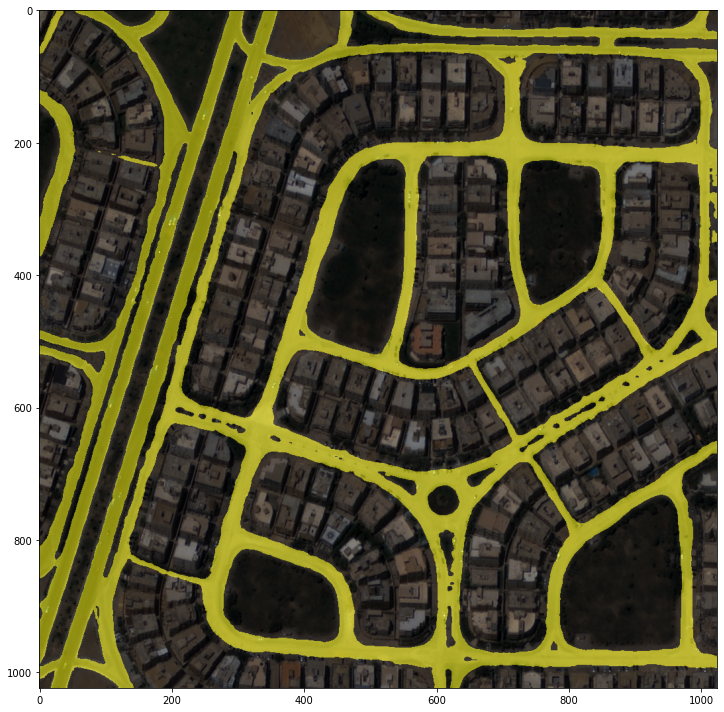

In [21]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD00002_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


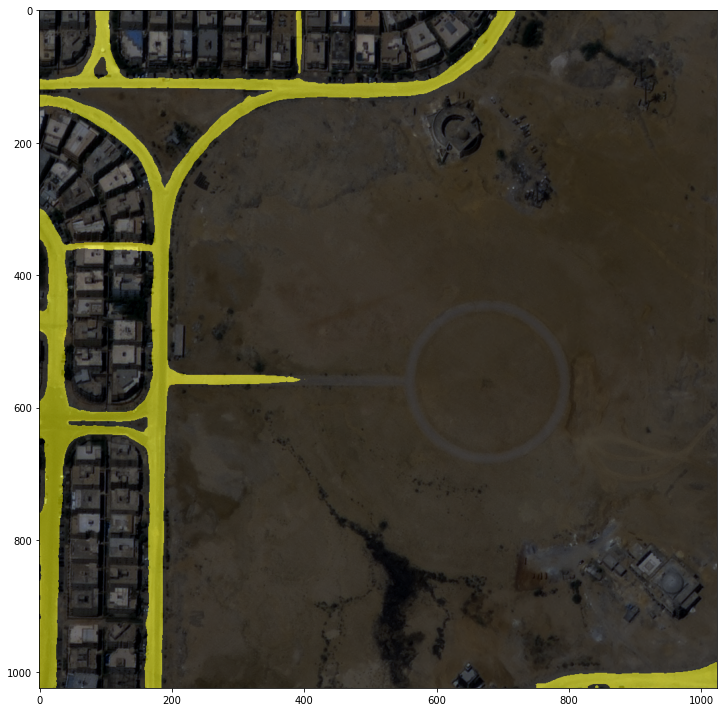

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD00010_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


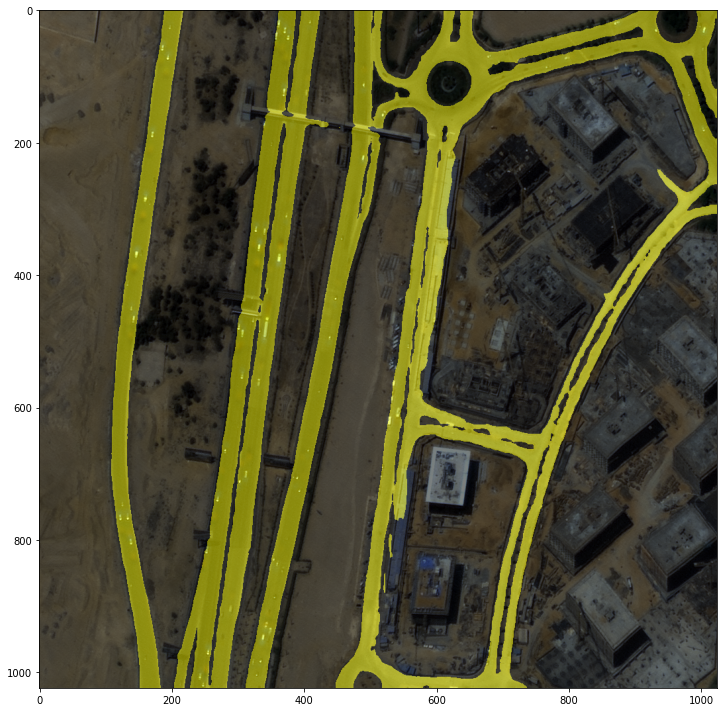

In [24]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD00047_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


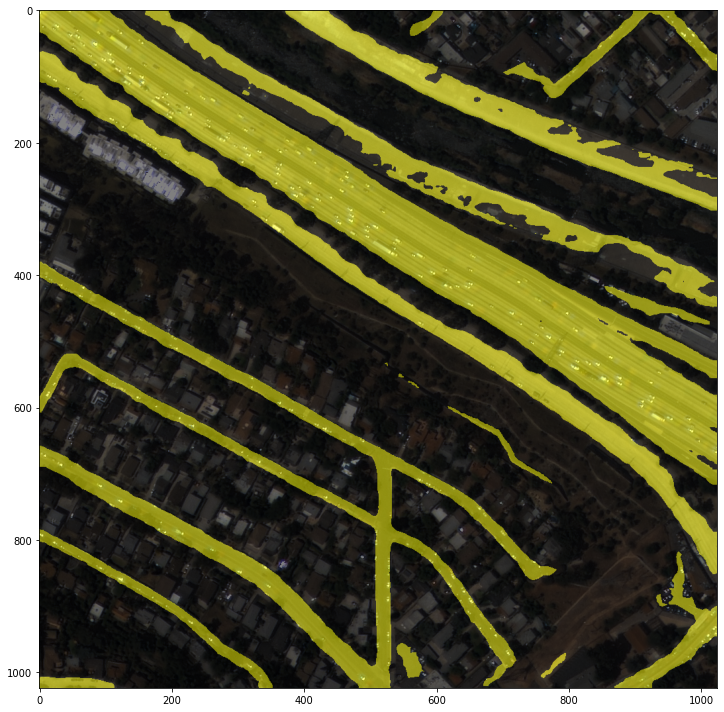

In [25]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD12071_PS3_K3A_NIA0391.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


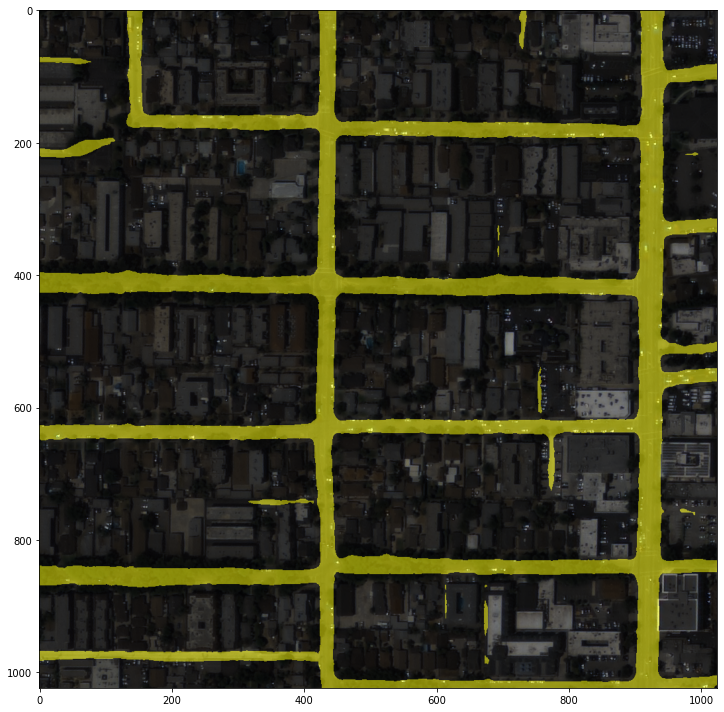

In [26]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD11907_PS3_K3A_NIA0391.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


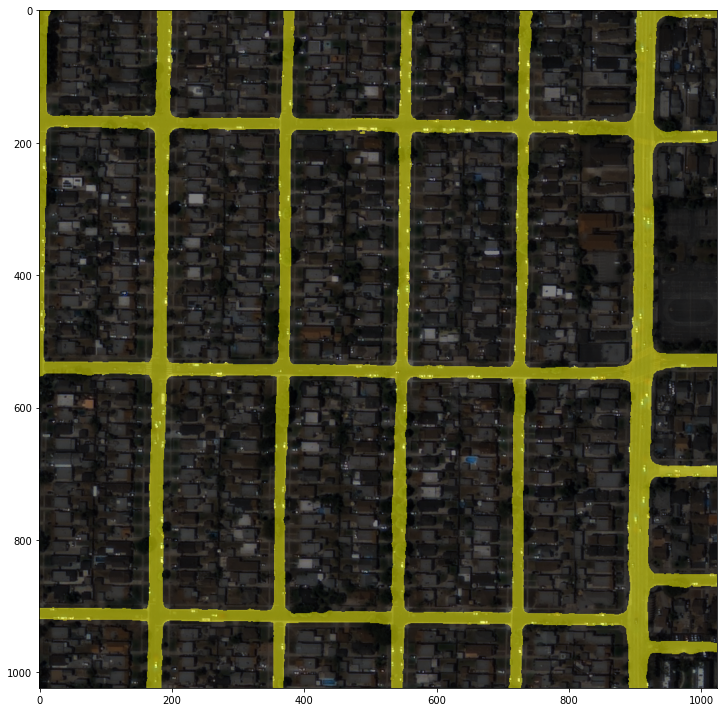

In [27]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD11611_PS3_K3A_NIA0390.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


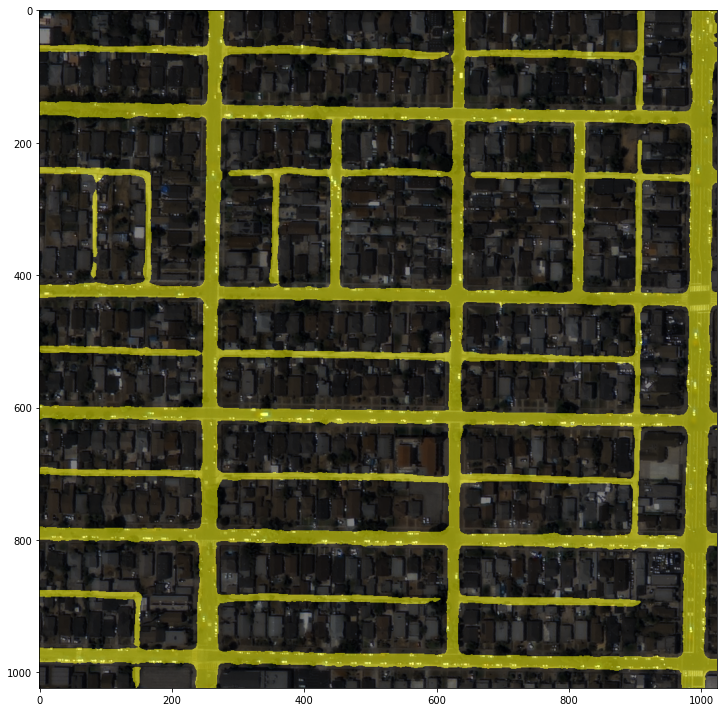

In [29]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD11474_PS3_K3A_NIA0390.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


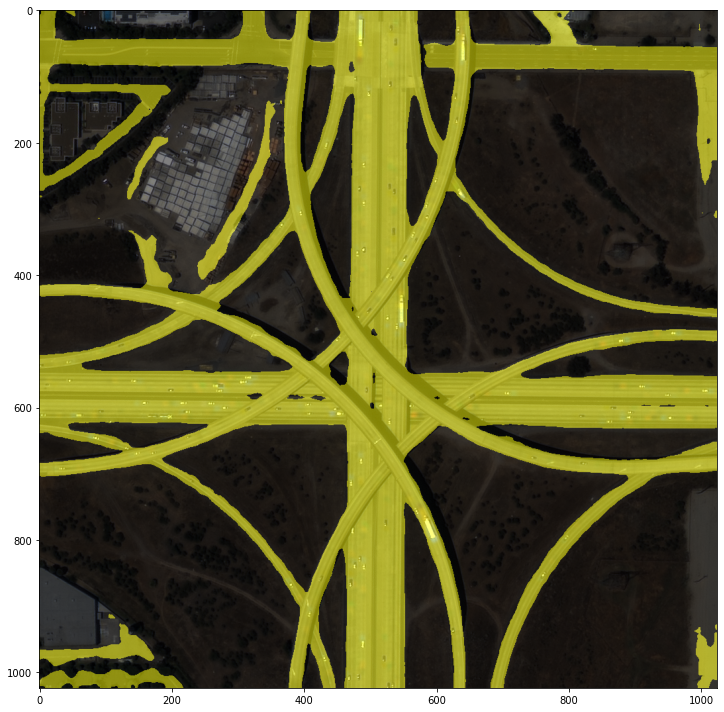

In [30]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD10413_PS3_K3A_NIA0388.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


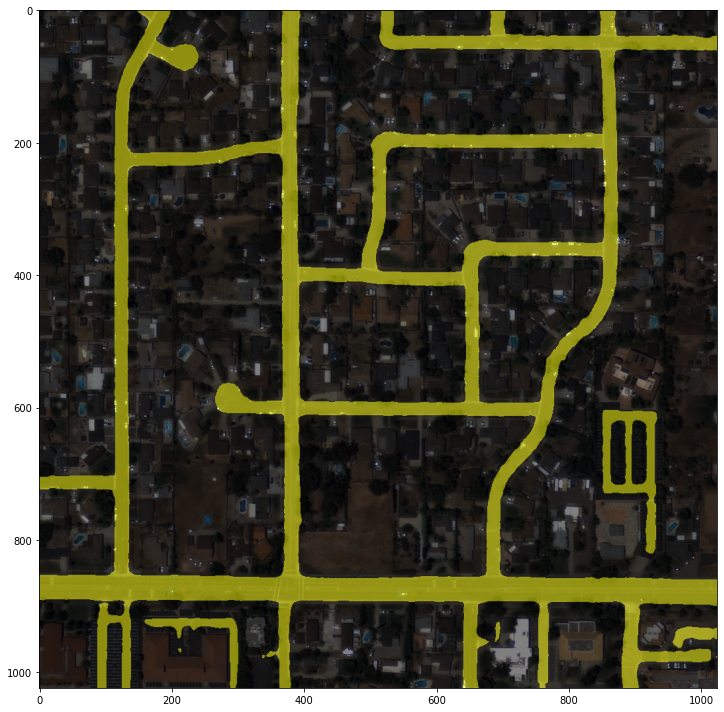

In [31]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD10150_PS3_K3A_NIA0388.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


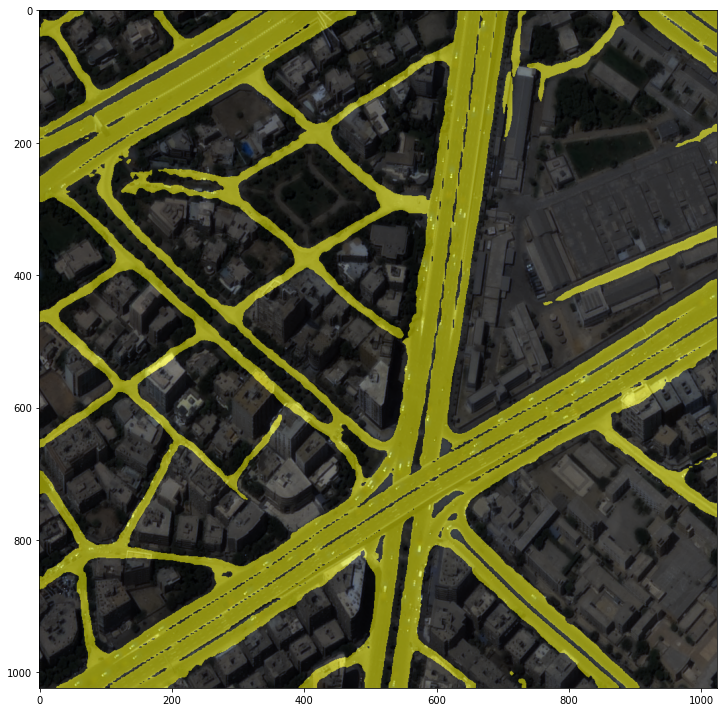

In [33]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/dice_focal_lovasz/iter_18000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/BLD00836_PS3_K3A_NIA0277.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)